# MRT OD Matrix in Singapore
> Assignment on clustering based on OD matrix in context of Singapore's Public Transportation System

- toc: true 
- badges: true
- comments: true
- categories: [sg]
- image: images/2022-08-21/tel2_sm-20-03-en-exp.png

## Introduction

In Singapore, one of the main forms of public transportation is via MRT/LRT. One assignment that I have performed is to use the commuting data for MRT and employ appropriate cluster analysis methods to group these stations into homogeneous groups using the origin-destination data. We are interested to find out the weekday AM (7-9am) and PM peak (5-7pm) for the journey-to-work and journey-to-home trips, and for weekend interaction during noon times (11-1pm). While the assignment was performed in SAS JMP Pro, I have included the concepts and reworked it using Python and its packages.



## Literature

Some useful literature for reading
-   [Public Transport OD matrices](https://www.diva-portal.org/smash/get/diva2:1523822/FULLTEXT01.pdf)
- [Identifying Functional Regions in Australia Using Hierarchical Aggregation Techniques](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1745-5871.2009.00631.x)

## Getting the data

Data can be found via the Land Transport Authority [Data Mall](https://datamall.lta.gov.sg/content/datamall/en.html) via an API call. I have also included the codes for API call but the accountkey have to be requested.

In [1]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport

In [13]:
# #to get files from lta datamall
# import requests
# def get_data():
#         url = 'http://datamall2.mytransport.sg/ltaodataservice/PV/ODTrain'
#         headers = {'AccountKey':'your key here','accept':'application/json'}
#         payload = {'Date':YYYYMM} 
#         return requests.get(url,params=payload,headers=headers).json()

# link = get_data()['value'][0]['Link']
# # extract csv from link for the month's data

In [2]:
# extract csv from link above for the month's data
df = pd.read_csv('origin_destination_train_202205.csv')
df = df.drop(['YEAR_MONTH','PT_TYPE'],axis=1)

## Displaying MRT stations and lines

For the purpose of visual displays, we will make use of the python package [Folium](https://python-visualization.github.io/folium/) to create a nice display of all the train stations. The coordinates of MRT stations as of now can be found pretty much anywhere, but i have used [this](https://github.com/hxchua/datadoubleconfirm) repo and added new stations manually.

In [3]:
import folium
from folium.plugins import MarkerCluster

In [4]:
#Load list of stations
mrt = pd.read_csv('mrt.csv')

def add_markers(stations,map,colour='default'):
    for stn in stations:
        stn_coor = list(mrt.loc[mrt['STN_NO']==stn,['Latitude','Longitude']].values[0])
        if colour=='default':
            stn_color = mrt.loc[mrt['STN_NO']==stn,['COLOR']].values[0][0].lower()
        else:
            stn_color = colour
        stn_full_name = mrt.loc[mrt['STN_NO']==stn,['STN_NAME']].values[0][0]

        if (ind1 := stn_full_name.find('MRT')) > -1:
            stn_name = stn_full_name[:ind1-1].title()
        elif (ind2 := stn_full_name.find('LRT')) > -1:
            stn_name = stn_full_name[:ind2-1].title()
        else:
            stn_name = stn_full_name

        if stn_color == 'gray':
            stn_color = 'lightgray'

        #print(stn_coor,stn_color,stn)
        folium.Marker(location=stn_coor, popup = stn+' '+stn_name,icon=folium.Icon(color=stn_color)).add_to(map)

Let's try to visualize the MRT systems maps by colour. Since folium doesn't have the color brown, I have used pink instead for the TEL line

![](image/2022-08-21/mrt_map.png)

## Exploratory Data Analysis

A useful package for basic EDA is through [Pandas Profiler](https://pypi.org/project/pandas-profiling/). You may visit their project website for more details/

Weekday number of total trips are higher than that of weekends. Mean trips for all stations are higher at 93 vs 50 for weekends. Peak OD is also highest for weekdays vs weekends

In [9]:
df.groupby('DAY_TYPE').describe()['TOTAL_TRIPS']

,count,mean,std,min,25%,50%,75%,max
DAY_TYPE,,,,,,,,
WEEKDAY,363723.0,93.888036,303.988433,1.0,4.0,15.0,59.0,12798.0
WEEKENDS/HOLIDAY,336106.0,50.504823,159.810852,1.0,3.0,9.0,32.0,5442.0


Let's try to find out the total trips by time for all stations for all days

In [10]:
df.groupby('TIME_PER_HOUR').describe()

TOTAL_TRIPS                                                \
                    count        mean         std  min  25%   50%   75%   
TIME_PER_HOUR                                                             
0                  3884.0    9.386972   20.068909  1.0  1.0   3.0   8.0   
5                 19572.0   27.882485   78.796186  1.0  2.0   6.0  21.0   
6                 32611.0   73.470087  244.369474  1.0  3.0  13.0  49.0   
7                 37441.0  108.842739  372.845040  1.0  4.0  17.0  66.0   
8                 38314.0   93.533669  310.211684  1.0  4.0  15.0  57.0   
9                 37626.0   64.812018  188.997212  1.0  3.0  11.0  43.0   
10                37812.0   58.559346  174.290314  1.0  3.0  10.0  37.0   
11                38699.0   60.849273  187.334462  1.0  3.0  10.0  38.0   
12                39760.0   66.604930  209.799559  1.0  3.0  11.0  42.0   
13                39870.0   69.337848  219.528833  1.0  3.0  12.0  43.0   
14                39623.0   65.880776  204.457741  1.0  3.0  11.0  42.0   
15                39987.0   68.949584  211.852530  1.0  4.0  12.0  45.0   
16                40995.0   76.218392  233.303667  1.0  4.0  14.0  50.0   
17                42318.0  106.590434  333.401763  1.0  5.0  18.0  69.0   
18                41708.0  120.898125  392.323923  1.0  5.0  18.0  73.0   
19                39260.0   84.383597  269.718346  1.0  4.0  14.0  52.0   
20                37155.0   66.658135  220.745056  1.0  3.0  11.0  40.0   
21                35917.0   61.105020  204.300373  1.0  3.0  10.0  37.0   
22                33151.0   43.948237  131.877848  1.0  2.0   8.0  29.0   
23                24126.0   24.061428   67.571074  1.0  2.0   5.0  17.0   

                        
                   max  
TIME_PER_HOUR           
0                230.0  
5               2067.0  
6               7058.0  
7              10811.0  
8               8510.0  
9               4904.0  
10              4580.0  
11              4662.0  
12              5523.0  
13              5585.0  
14              5380.0  
15              6510.0  
16              8898.0  
17             10503.0  
18             12798.0  
19              8755.0  
20              7971.0  
21              7423.0  
22              3776.0  
23              2865.0

Morning Peak and PM Peak have the highest mean numbers, not surprisingly. We try to separate it by weekdays and weekends to see if there is any difference

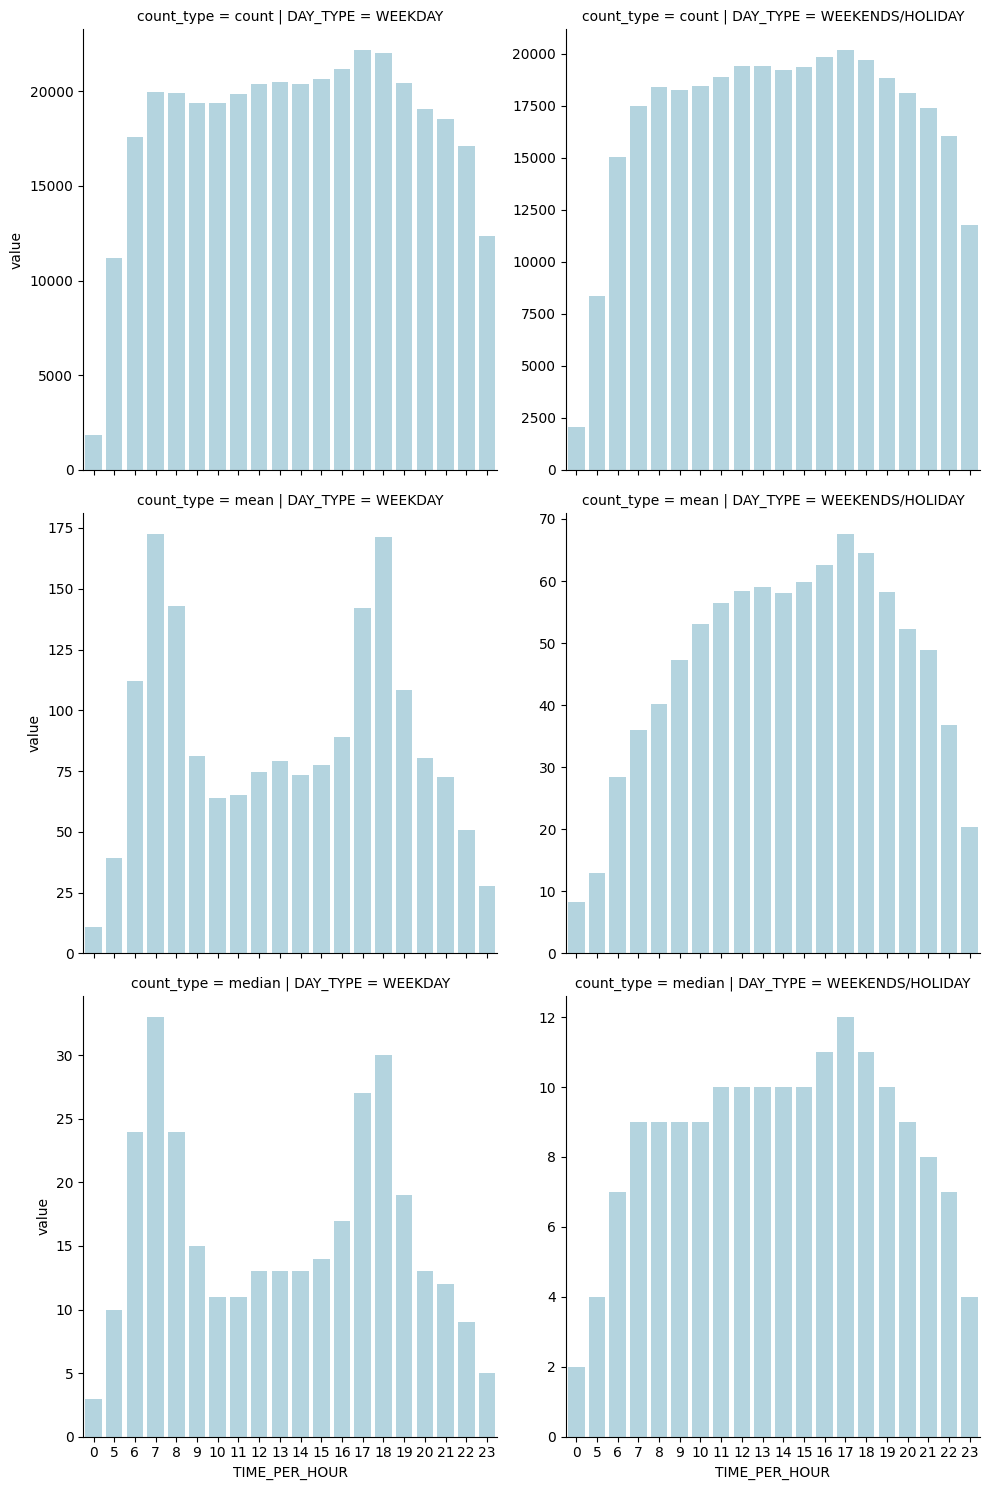

In [11]:
#collapse-output
df_total_trips = df.groupby(['DAY_TYPE','TIME_PER_HOUR']).describe()['TOTAL_TRIPS'][['count','50%','mean']].rename(columns={'50%':'median'}).reset_index()
df_total_trips=df_total_trips.melt(id_vars=['DAY_TYPE','TIME_PER_HOUR'],var_name='count_type')
g = sns.catplot(data=df_total_trips,x='TIME_PER_HOUR',y='value',col='DAY_TYPE',
            row='count_type',kind='bar',row_order=['count','mean','median'],sharey=False,color='lightblue')
# for ax in g.axes:
#     ax.tick_params(labelbottom=True)
plt.show()

We plot the graphs of the total trips by hours for both weekday and weekends. Not surprisingly, the mean and median trips are the highest during the AM and PM peak during weekdays. For weekends, the number of trips are generally constant throughout the day, with smaller number at the beginning and end of day.

How about the total trips by stations? We can have 2 groups, by origin and by destination. First, by origin.

In [12]:
df.groupby('ORIGIN_PT_CODE')['TOTAL_TRIPS'].mean().reset_index().sort_values('TOTAL_TRIPS',ascending=False)

,ORIGIN_PT_CODE,TOTAL_TRIPS
76,EW24/NS1,259.187846
119,NS21/DT11,208.347993
72,EW2/DT32,205.494127
120,NS22,203.382958
110,NS13,199.930361
...,...,...
160,TE5,12.613582
142,PW6,12.354680
152,SW4,11.462328
138,PW1,9.931076


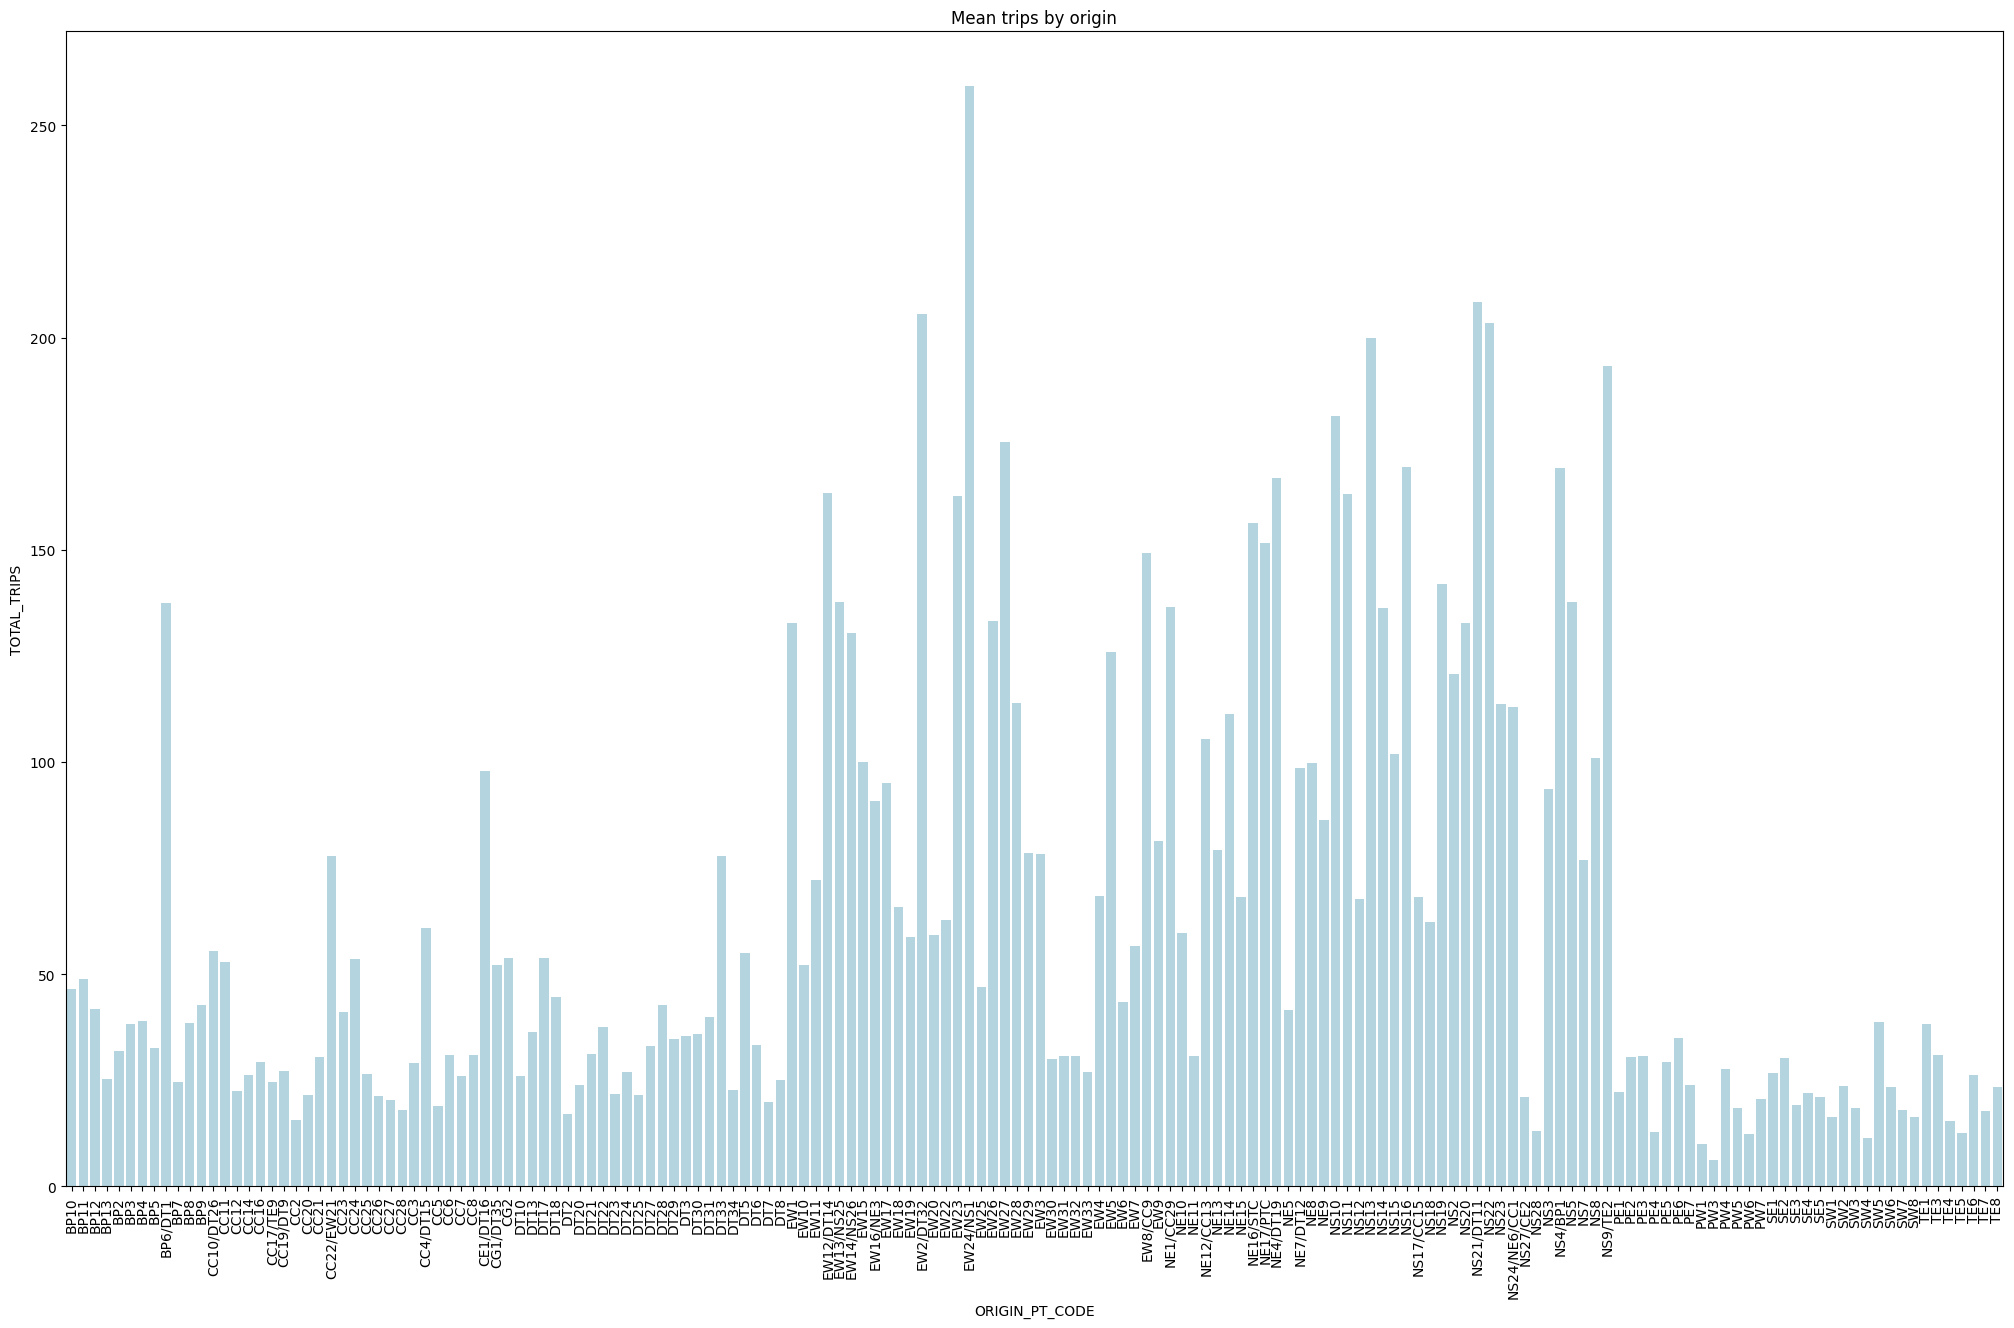

In [13]:
#collapse-output
plt.figure(figsize=(25,15))
g=sns.barplot(data=df.groupby('ORIGIN_PT_CODE')['TOTAL_TRIPS'].mean().reset_index(),x='ORIGIN_PT_CODE',y='TOTAL_TRIPS',color='lightblue')
plt.xticks(rotation=90)
plt.title('Mean trips by origin')
plt.show()

For analysis of the number of trips by origin, we can clearly see there are some areas that have higher volumes, for example the top 3 volume are at EW24/NS1 (Jurong East) at 259 trips, NS21/DT11	(Newton) at 208 trips and EW2/DT32 (Tampines) at 205 trips.

In [14]:
df.groupby('DESTINATION_PT_CODE')['TOTAL_TRIPS'].mean().reset_index().sort_values('TOTAL_TRIPS',ascending=False)

,DESTINATION_PT_CODE,TOTAL_TRIPS
76,EW24/NS1,261.409655
120,NS22,220.397902
130,NS9/TE2,220.258299
119,NS21/DT11,214.947722
110,NS13,210.738939
...,...,...
124,NS28,12.187382
152,SW4,11.871693
142,PW6,11.335381
138,PW1,9.417886


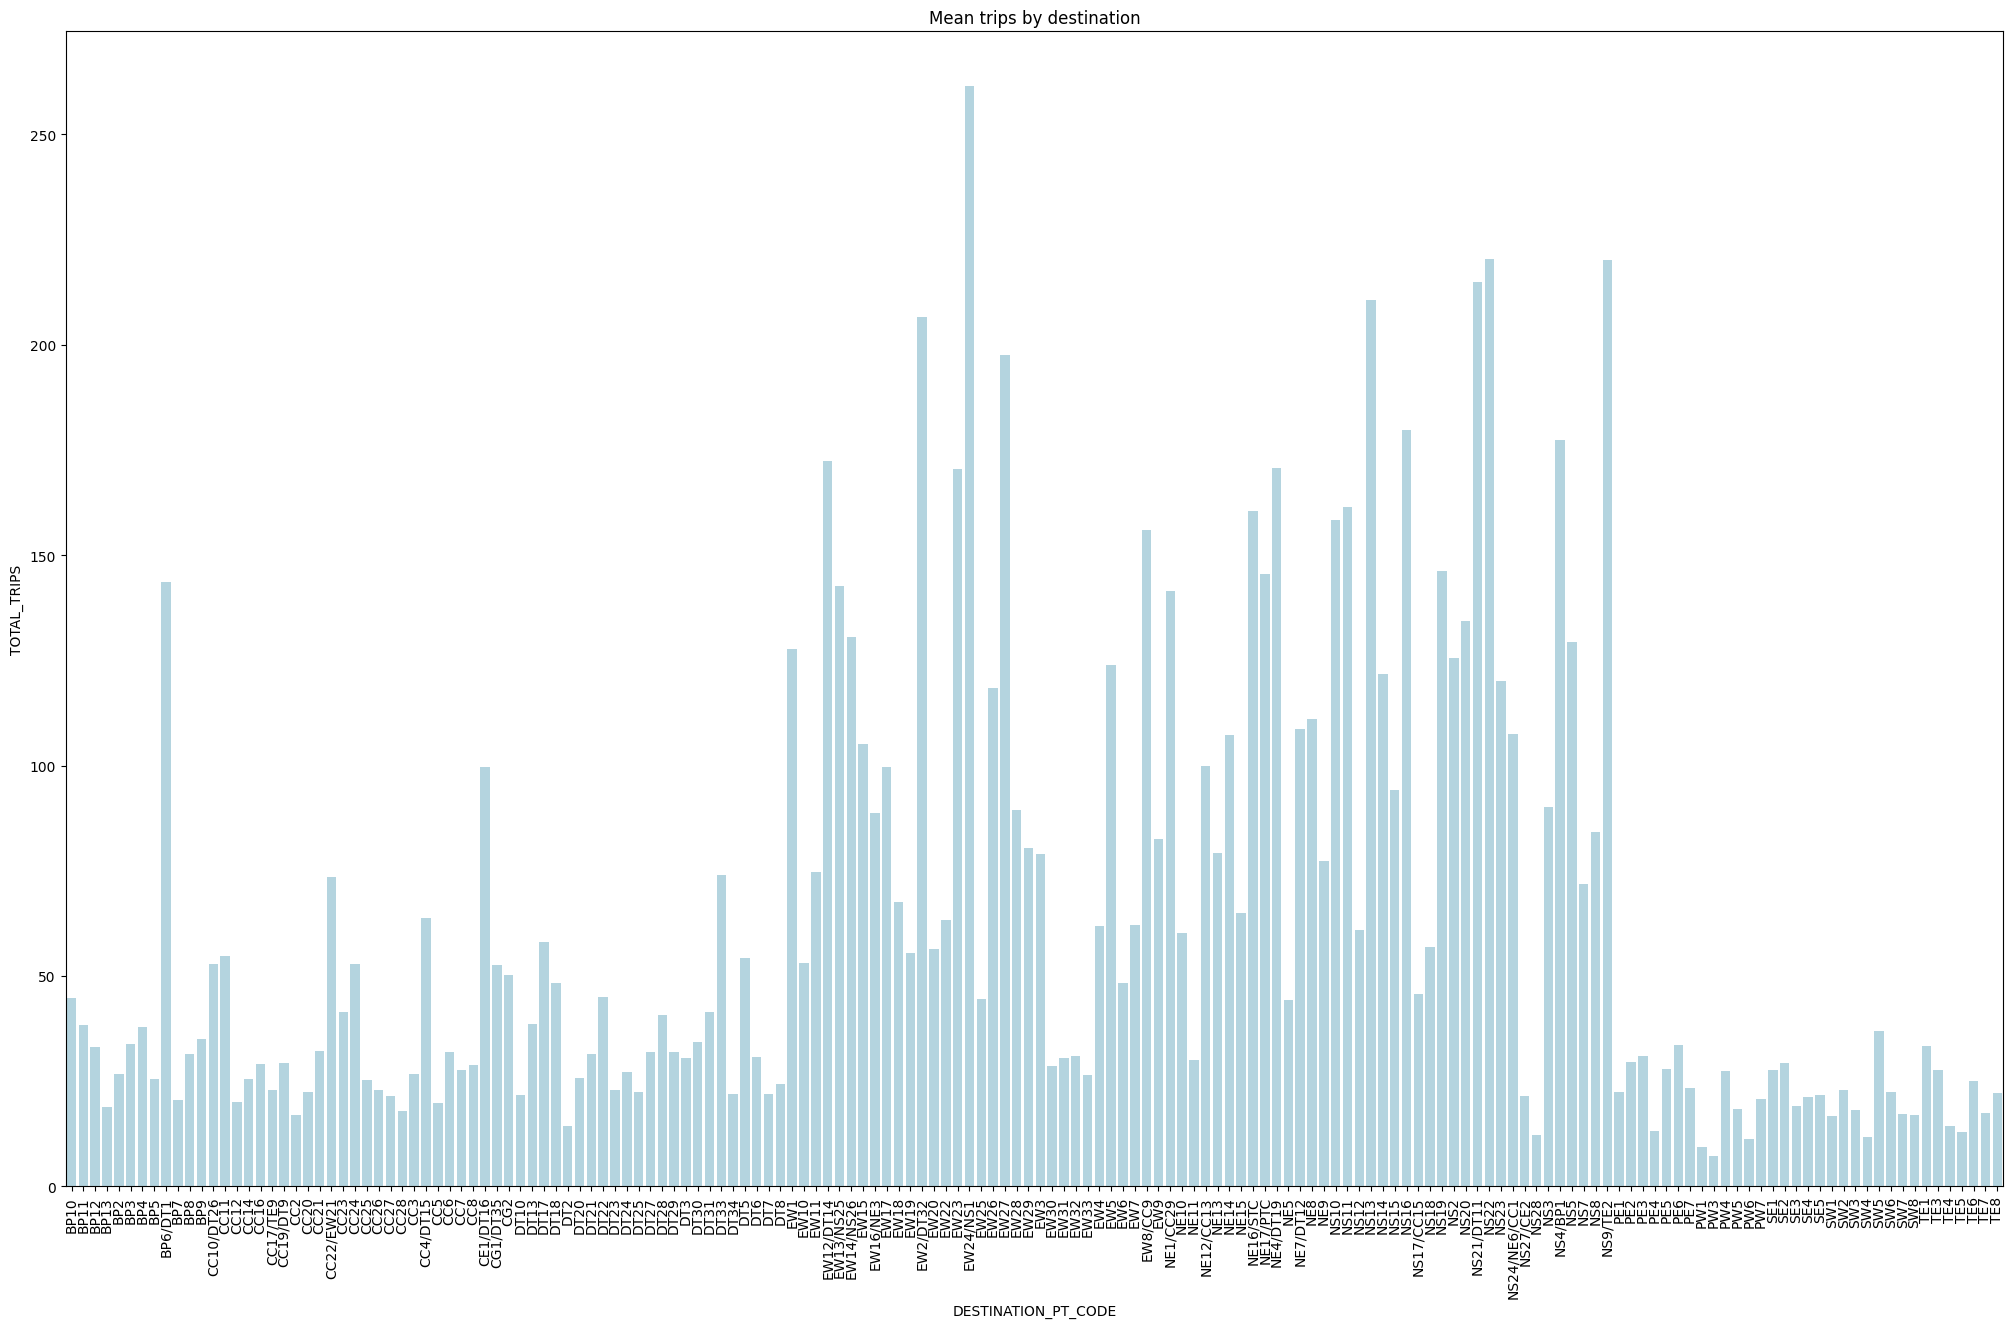

In [15]:
#collapse-output
plt.figure(figsize=(25,15))
g=sns.barplot(data=df.groupby('DESTINATION_PT_CODE')['TOTAL_TRIPS'].mean().reset_index(),x='DESTINATION_PT_CODE',y='TOTAL_TRIPS',color='lightblue')
plt.xticks(rotation=90)
plt.title('Mean trips by destination')
plt.show()

Similarly for number of trips by destination, the top 3 volume are at EW24/NS1 (Jurong East) at 261 trips, NS22 (Orchard) at 220 trips and NS9/TE2 (Woodlands) at 220 trips.


## Weekday AM Peak (7-9am)

### Preparing data into OD matrix

- Segmentise into weekday morning peak, weekday evening peak, weekends peak
- sum of total trips by origin and destination
- standardisation of data (min-max scaler) with sum of sum of origin and destination

In [16]:
#Filter to show Weekday AM Peak (7-9am)
weekday_am_peak = df[(df['DAY_TYPE']=='WEEKDAY') & (df['TIME_PER_HOUR']<=9) & (df['TIME_PER_HOUR']>=7)].drop(columns=['DAY_TYPE'])
weekday_am_peak=weekday_am_peak.groupby(['ORIGIN_PT_CODE','DESTINATION_PT_CODE']).sum().reset_index().drop(columns=['TIME_PER_HOUR'])

In [17]:
#collapse_output
# To transform and find out the total_trips per pair as a pct of trips by the sum of trips from each origin station
 
weekday_am_peak.groupby('ORIGIN_PT_CODE')['TOTAL_TRIPS'].transform('sum')
weekday_am_peak['sum_total_trips_origin']=weekday_am_peak.groupby('ORIGIN_PT_CODE')['TOTAL_TRIPS'].transform('sum')
weekday_am_peak['pct_trips_sum_origin']=weekday_am_peak['TOTAL_TRIPS']/weekday_am_peak['sum_total_trips_origin']

#Creating OD matrix with origins as rows and destinations as columns, values as the normalised trips by origin
od_weekdayam_mat = weekday_am_peak.pivot(index='ORIGIN_PT_CODE',columns='DESTINATION_PT_CODE',values='pct_trips_sum_origin').fillna(0)
od_weekdayam_mat

DESTINATION_PT_CODE,BP10,BP11,BP12,BP13,BP2,BP3,BP4,BP5,BP6/DT1,BP7,...,SW6,SW7,SW8,TE1,TE3,TE4,TE5,TE6,TE7,TE8
ORIGIN_PT_CODE,,,,,,,,,,,,,,,,,,,,,
BP10,0.000000,0.019253,0.046300,0.019304,0.005552,0.008863,0.033464,0.042429,0.356390,0.022819,...,0.0,0.0,0.000000,0.007793,0.000306,0.001019,0.000611,0.000509,0.001121,0.000102
BP11,0.011440,0.000000,0.010368,0.013025,0.006255,0.010711,0.037875,0.031234,0.404542,0.013239,...,0.0,0.0,0.000000,0.014781,0.001371,0.000171,0.000300,0.000000,0.000086,0.000086
BP12,0.021518,0.008227,0.000000,0.008803,0.007882,0.011219,0.041252,0.024912,0.427881,0.008170,...,0.0,0.0,0.000000,0.014844,0.000288,0.000000,0.000000,0.000230,0.000173,0.000058
BP13,0.039606,0.017033,0.045044,0.000000,0.018059,0.012415,0.047917,0.011492,0.222450,0.003489,...,0.0,0.0,0.000000,0.016827,0.000205,0.000103,0.000000,0.000000,0.000103,0.000000
BP2,0.010395,0.004921,0.014212,0.005243,0.000000,0.007359,0.024791,0.018398,0.345690,0.004507,...,0.0,0.0,0.000000,0.015730,0.000184,0.000966,0.000000,0.000092,0.001380,0.001058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TE4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000907,0.006166,0.000000,0.000363,0.000000,...,0.0,0.0,0.000544,0.106456,0.054044,0.000000,0.019405,0.052956,0.087777,0.060936
TE5,0.000000,0.000000,0.000098,0.000000,0.000000,0.000295,0.007864,0.001180,0.000491,0.000295,...,0.0,0.0,0.000000,0.153642,0.026639,0.023690,0.000000,0.029981,0.053868,0.036371
TE6,0.000036,0.000000,0.000107,0.000071,0.000000,0.000285,0.006656,0.000356,0.002598,0.000036,...,0.0,0.0,0.000036,0.122762,0.018473,0.013561,0.008578,0.000000,0.078946,0.040648


In [21]:
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

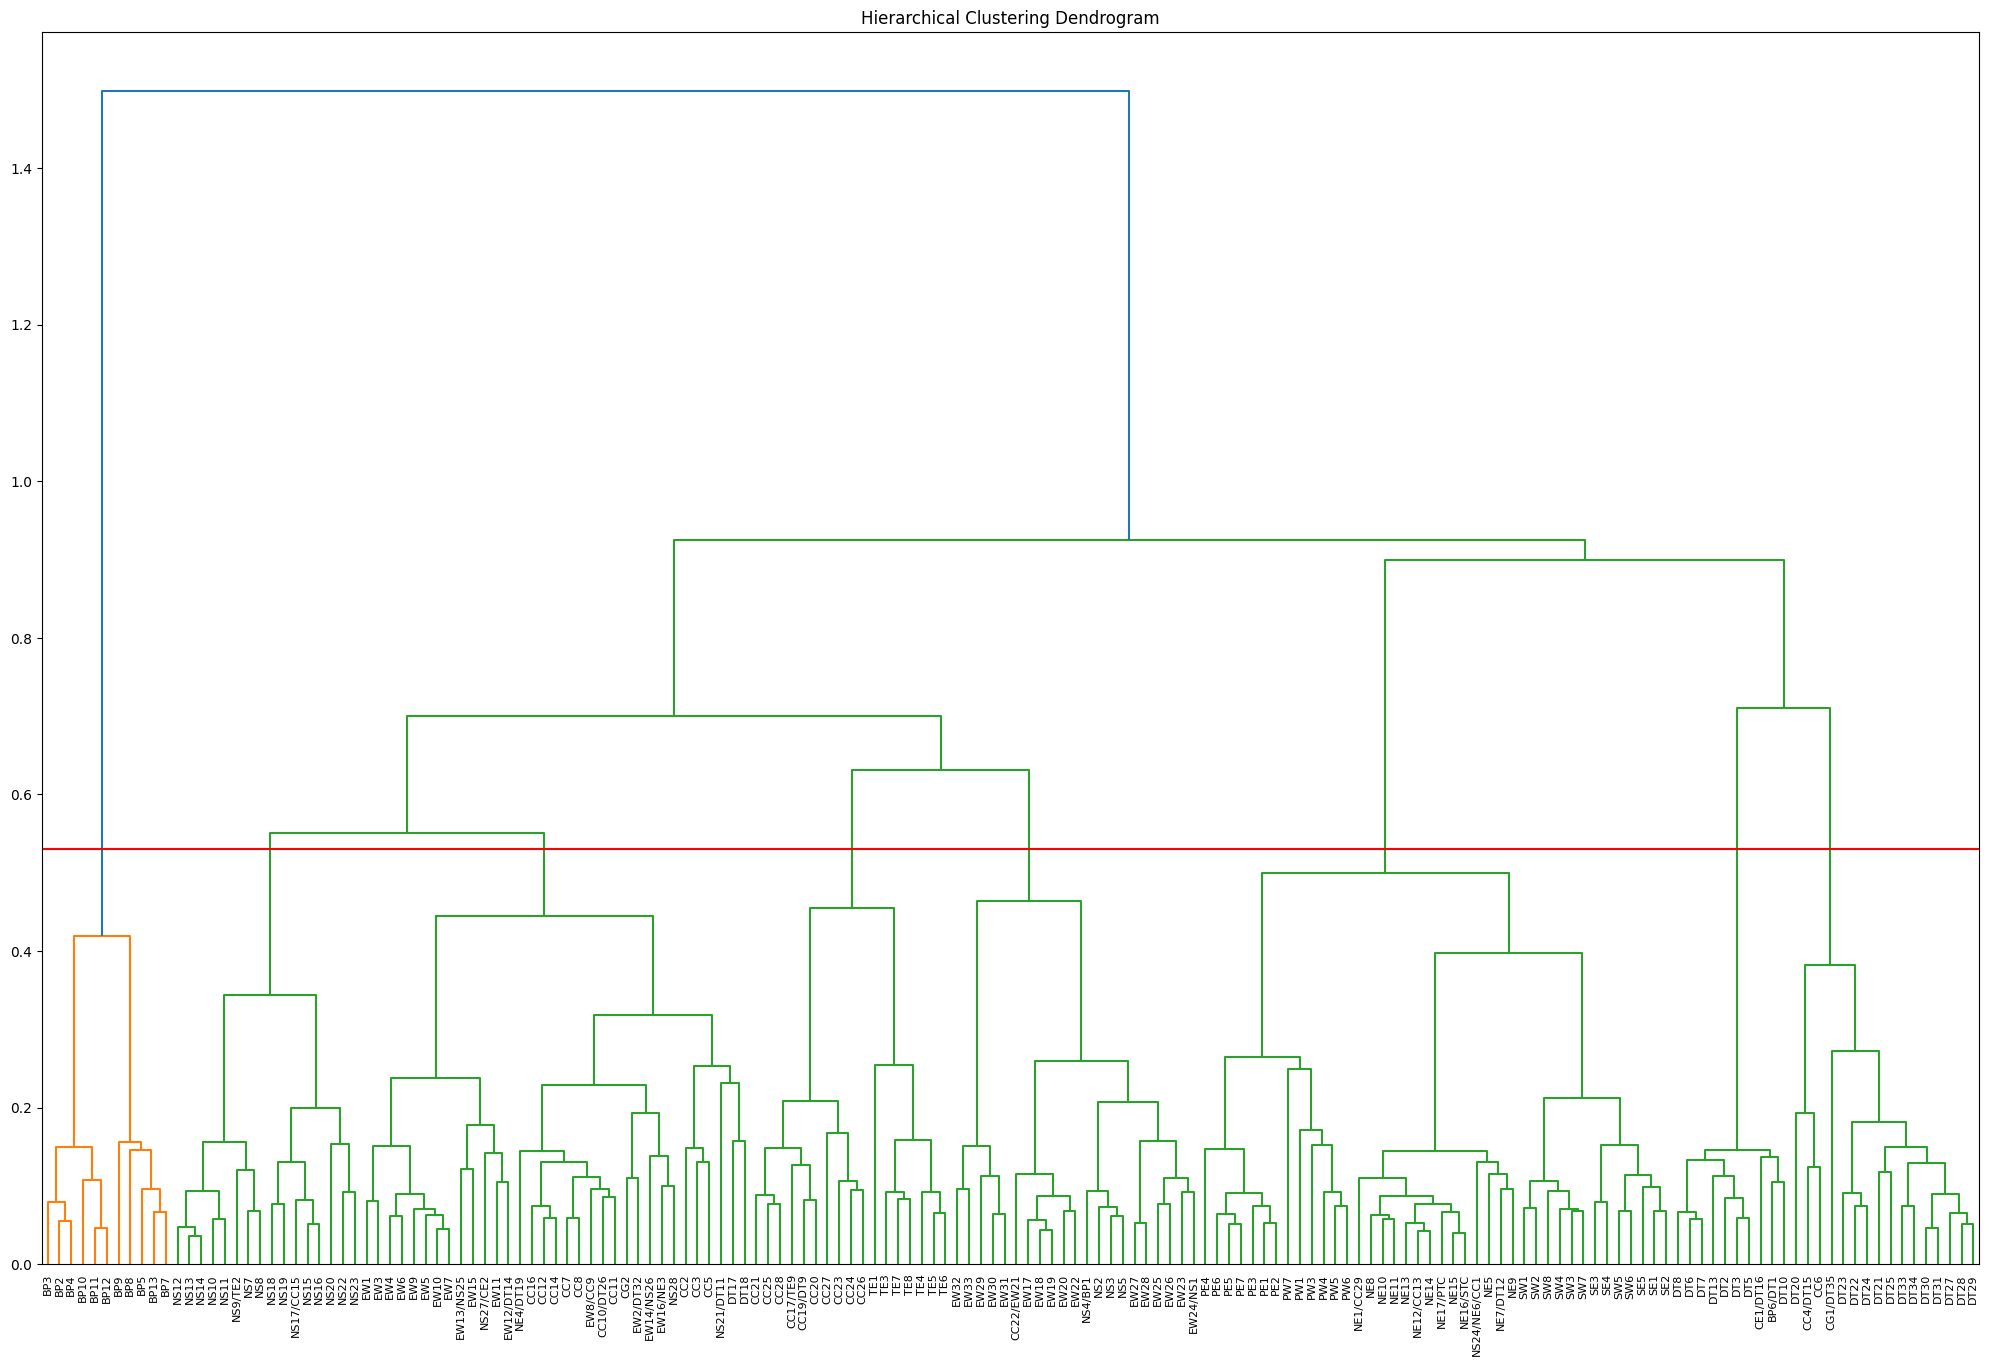

In [19]:
#collapse-output
# # hierarchical clustering and display dendogram

def plot_dendrogram(data: pd.DataFrame, **kwargs):
    clusters = shc.linkage(data,**kwargs)
    plt.figure(figsize=(25,16))
    plt.title("Hierarchical Clustering Dendrogram")
    shc.dendrogram(Z=clusters,leaf_font_size=8,labels=data.index)
    plt.axhline(y = 0.53, color = 'r', linestyle = '-')
    plt.show()

plot_dendrogram(od_weekdayam_mat,method='ward',metric='euclidean')

Finding the optimal cluster size in agglomerative hierarchical clustering is to find out the largest horizontal space that doesn't have any vertical lines(space with the longest vertical lines), with the number of clusters being the vertical lines that cut the horizontal line. This meant that the separation between clusters are the largest. We can draw the horizontal line by eyeballing the y values. Here, the number of times that the horizontal line cuts through is 8.

As the default euclidean distance metric with ward linkages works well, we will stick to the defaults. We also mentioned the default values here for simplicity of changing the linkage and affinity in order to tweak them later if needed.

In [23]:
## get df of clusters results using cluster size found

def agg_cluster_fit(data: pd.DataFrame,cluster_size: int, **kwargs):
    model = AgglomerativeClustering(n_clusters=cluster_size,**kwargs) #affinity='euclidean', linkage='ward'
    model.fit(data)

    data['label'] = model.labels_

    d = [','.join(data[data['label']==x].index) for x in range(cluster_size)]
    df = pd.DataFrame(index=range(1,cluster_size+1),columns=['Stations'],data=d)

    return df


weekday_am_peak_clusters = agg_cluster_fit(data=od_weekdayam_mat,cluster_size=8,affinity='euclidean', linkage='ward')
weekday_am_peak_clusters.style.set_properties(**{'text-align': 'left'})

,Stations
1,"NE1/CC29,NE10,NE11,NE12/CC13,NE13,NE14,NE15,NE16/STC,NE17/PTC,NE5,NE7/DT12,NE8,NE9,NS24/NE6/CC1,PE1,PE2,PE3,PE4,PE5,PE6,PE7,PW1,PW3,PW4,PW5,PW6,PW7,SE1,SE2,SE3,SE4,SE5,SW1,SW2,SW3,SW4,SW5,SW6,SW7,SW8"
2,"CC17/TE9,CC19/DT9,CC20,CC21,CC23,CC24,CC25,CC26,CC27,CC28,TE1,TE3,TE4,TE5,TE6,TE7,TE8"
3,"CC22/EW21,EW17,EW18,EW19,EW20,EW22,EW23,EW24/NS1,EW25,EW26,EW27,EW28,EW29,EW30,EW31,EW32,EW33,NS2,NS3,NS4/BP1,NS5"
4,"BP10,BP11,BP12,BP13,BP2,BP3,BP4,BP5,BP7,BP8,BP9"
5,"CC4/DT15,CC6,CG1/DT35,DT20,DT21,DT22,DT23,DT24,DT25,DT27,DT28,DT29,DT30,DT31,DT33,DT34"
6,"CC10/DT26,CC11,CC12,CC14,CC16,CC2,CC3,CC5,CC7,CC8,CG2,DT17,DT18,EW1,EW10,EW11,EW12/DT14,EW13/NS25,EW14/NS26,EW15,EW16/NE3,EW2/DT32,EW3,EW4,EW5,EW6,EW7,EW8/CC9,EW9,NE4/DT19,NS21/DT11,NS27/CE2,NS28"
7,"NS10,NS11,NS12,NS13,NS14,NS15,NS16,NS17/CC15,NS18,NS19,NS20,NS22,NS23,NS7,NS8,NS9/TE2"
8,"BP6/DT1,CE1/DT16,DT10,DT13,DT2,DT3,DT5,DT6,DT7,DT8"


Lets try to visualize the clusters on a map. Each cluster is set to a different colour so that we can identify the stations in a cluster easily.

We can see that the clustering algorithm strongly favours MRT/LRT stations that lies on the same MRT/LRT line, and also within the same region in Singapore. 

## Closing Thoughts

Since this was one of the first assignments that I have done in my data science journey, there are several items that I may could have done in addition. For example, we could have done clustering analysis for both origin and destinations to uncover the clusters in both direction. This could have revealed interesting insights on travel patterns. Also, I could have only used data from major hubs to identify where people are working, and if people choose their work location nearer to their homes and the extent of it. We could also have used PCA/SVD analysis to further identify possible number of clusters. Also, I could have applied time series analysis to identify trends within a month or across months, and especially during pre and periods of COVID-19 relaxation periods.